In [1]:
import sys, os
import numpy as np
sys.path.append('/home/nam4/Desktop/sandbox/')
import FHMCAnalysis
import FHMCAnalysis.moments.histogram.one_dim.ntot.gc_hist as hG
import FHMCAnalysis.moments.win_patch.chkpt_patch as wP
import FHMCAnalysis.moments.win_patch.chkpt_equil as wE

# Fluid

In [2]:
temp = 1.5 # reference temperature of simulations

In [3]:
sig22 = 1.50 # information about fluid that was simulated
eps22 = 4/3.
sig11 = 1.00
eps11 = 1.00

# Get Simulations

In [13]:
head = './'

In [14]:
smooth = 60 # How many points in N_tot space to smooth lnPI over when looking for maxima

histograms = []
for d in sorted([dd for dd in os.listdir(head) if 'dMu2' in dd]):
    dMu2 = float(d.split('_')[1])
    hist = hG.histogram (fname=head+'/'+d+'/composite.nc', beta_ref=1.0/temp, mu_ref=[0.0, 0.0+dMu2], smooth=smooth)
    histograms.append((dMu2,hist))

# Construct Isopleths

In [20]:
import FHMCAnalysis.moments.histogram.one_dim.ntot.gc_binary as gB
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
target_beta = 1.0/1.40 # target (inverse) temperature
order = 2 # max order to extrapolate with
m = 2.5 # exponent to mix neigbors with

In [22]:
iso = gB.isopleth ([x[1] for x in histograms], beta_target=target_beta, order=order)

In [71]:
grid_x1, grid_mu = iso.make_grid_multi([-10, -5], [-2, 2], [0.1, 0.1], m=m)

(-5, 5)

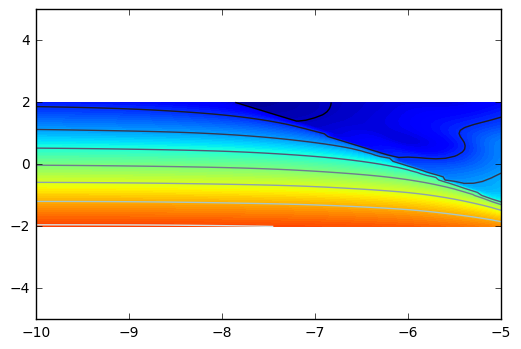

In [72]:
csf = plt.contourf(grid_mu[0], grid_mu[1], grid_x1, levels=np.linspace(0.05, 0.95, 100))
cs = plt.contour(grid_mu[0], grid_mu[1], grid_x1, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], cmap='bone')
plt.ylim(-5,5)

# Extract Desired Isopleth for Analysis

In [73]:
x1 = 0.5 # Choose a mole fraction of species 1 to examine

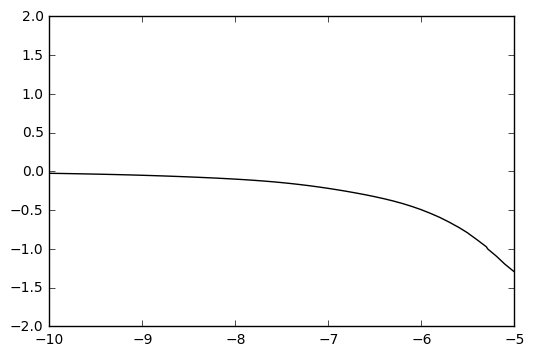

In [74]:
mu_vals = gB.get_iso (x1, grid_x1, grid_mu[0], grid_mu[1]) # get isopleth

## Need to parameterize pressure and overall packing fraction

In [75]:
from scipy.interpolate import interp1d

In [76]:
V = 10.0*10.0*10.0 # Volume known a priori
p = -iso.data['F.E./kT']/V/target_beta
phi = np.pi/6.0*((sig11**3)*x1*iso.data['density']+(sig22**3)*(1.0-x1)*iso.data['density'])

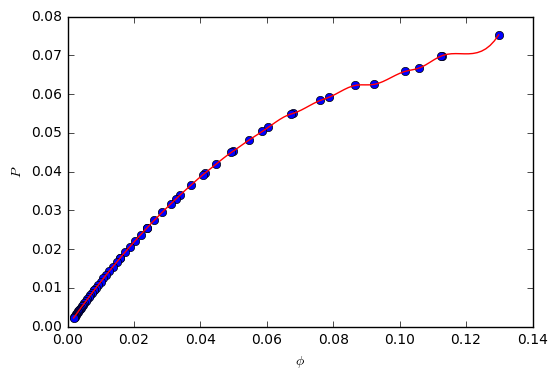

In [77]:
xy = gB.parameterize_mesh (grid_mu[0], grid_mu[1], phi, p, mu_vals)
phi_v = np.array([x[0] for x in xy])
p_v = np.array([x[1] for x in xy])
plt.plot(phi_v, p_v, 'o')
plt.xlabel(r'$\phi$')
plt.ylabel(r'$P$')

# Interpolate to smooth / use to compute arbitrary results
f = interp1d(phi_v, p_v, kind='cubic')
t = np.linspace(np.min(phi_v), np.max(phi_v), 100)
plt.plot(t, f(t), 'r') 

## Now have continuous function of P(phi)

In [81]:
packing_frac = 0.02

In [82]:
f(packing_frac)

array(0.021780202690230552)

# Estimate the Thermodynamic Correction Factor ($Q_1$)

## At this T, x1, and $\phi$ we can now compute P, $Q_1$

P =  0.0217802026902
Q_1 =  0.934803303679
T =  1.4


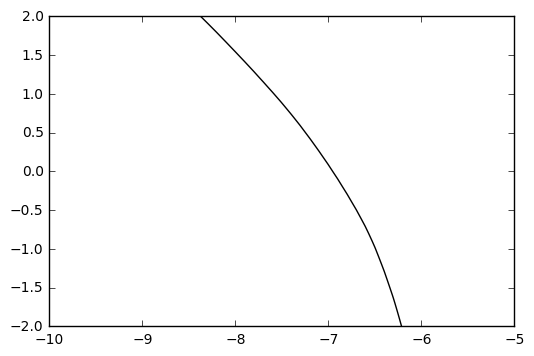

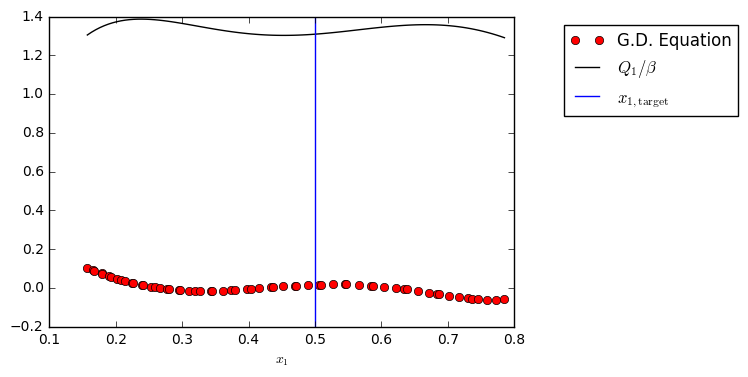

In [84]:
err2 = gB.check_gibbs_duhem(isobars=np.array([f(packing_frac)]), grid_x1=grid_x1, grid_p=p, grid_mu1=grid_mu[0], grid_dmu2=grid_mu[1], k=5, s=0.001)

plt.figure()
for p_, e_, x1_, d_, q_beta in err2:
    plt.plot(x1_, e_, marker='o', lw=0, color='r', label='G.D. Equation')
    
    # Parameterize x1 vs. q1/beta
    f2 = interp1d(x1_, q_beta, kind='cubic')
    t = np.linspace(np.min(x1_), np.max(x1_), 100)
    plt.plot(t, f2(t), 'k', label=r'$Q_1/\beta$') 
    plt.axvline(x=x1, label=r'$x_{\rm 1,target}$')
    
    plt.xlabel(r'$x_1$')
    plt.legend(bbox_to_anchor=(1.5,1))
    
    # Estimate q1
    print 'P = ', f(packing_frac)
    print 'Q_1 = ', f2(x1)*target_beta
    print 'T = ', 1.0/target_beta